# Ultimate Technologies Inc. - Take Home Challenge

## Part 1 - Exploratory Data Analysis

In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Load data
logins = pd.read_json('logins.json')

In [3]:
# Inspect logins
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
# Sort values to ensure they are in sequential order
logins.sort_values('login_time', inplace=True)

In [5]:
# Check info for null values and dtype
logins.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93142 entries, 6 to 93140
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.4 MB


No null values

In [6]:
# Set datetime column to index
logins.set_index('login_time', inplace=True)

In [7]:
# Create column of 1's representing a log-in in at that time
logins['LoginFreq']=1

### By 15 Minute Intervals

In [8]:
# Resample 
logins = logins.resample('15min').count()

In [9]:
logins['weekday'] = logins.index.day_name()

In [10]:
logins.head()

,LoginFreq,weekday
login_time,,
1970-01-01 20:00:00,2,Thursday
1970-01-01 20:15:00,6,Thursday
1970-01-01 20:30:00,9,Thursday
1970-01-01 20:45:00,7,Thursday
1970-01-01 21:00:00,1,Thursday


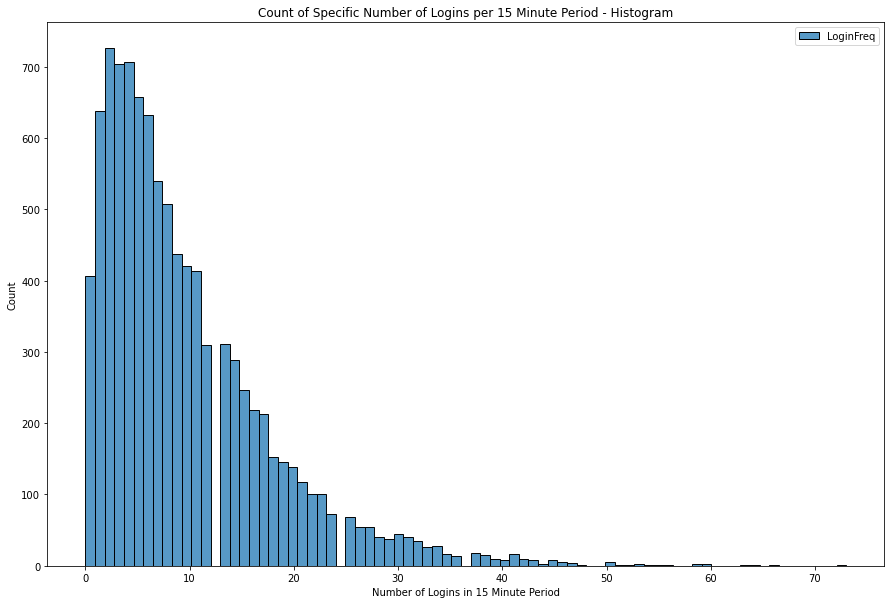

In [11]:
# Plot histogram of logins per 15 minute period
_ = plt.figure(figsize=(15,10))
_ = sns.histplot(logins)
_ = plt.title('Count of Specific Number of Logins per 15 Minute Period - Histogram')
_ = plt.xlabel('Number of Logins in 15 Minute Period')

Data are skewed

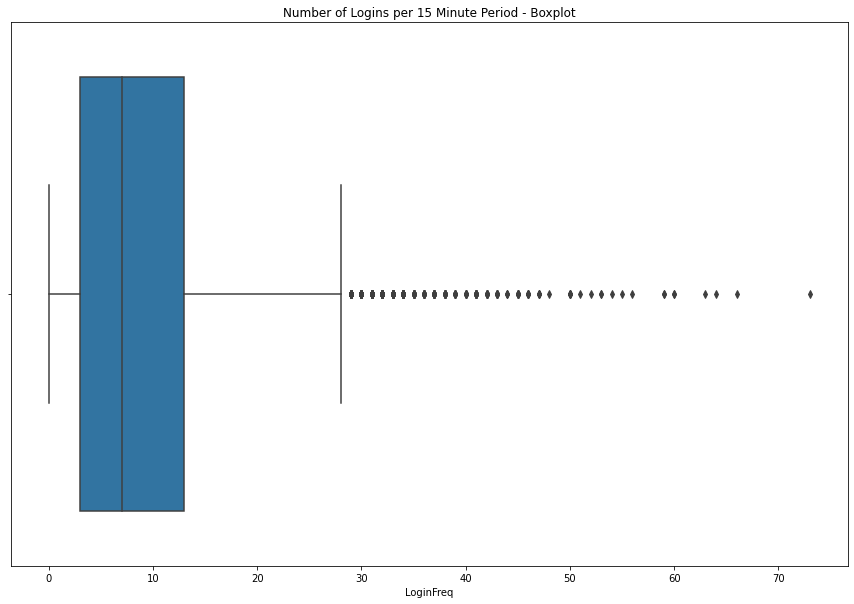

In [12]:
# Plot boxplot of logins per 15 minute period
_ = plt.figure(figsize=(15,10))
_ = sns.boxplot(data=logins, x='LoginFreq')
_ = plt.title('Number of Logins per 15 Minute Period - Boxplot')

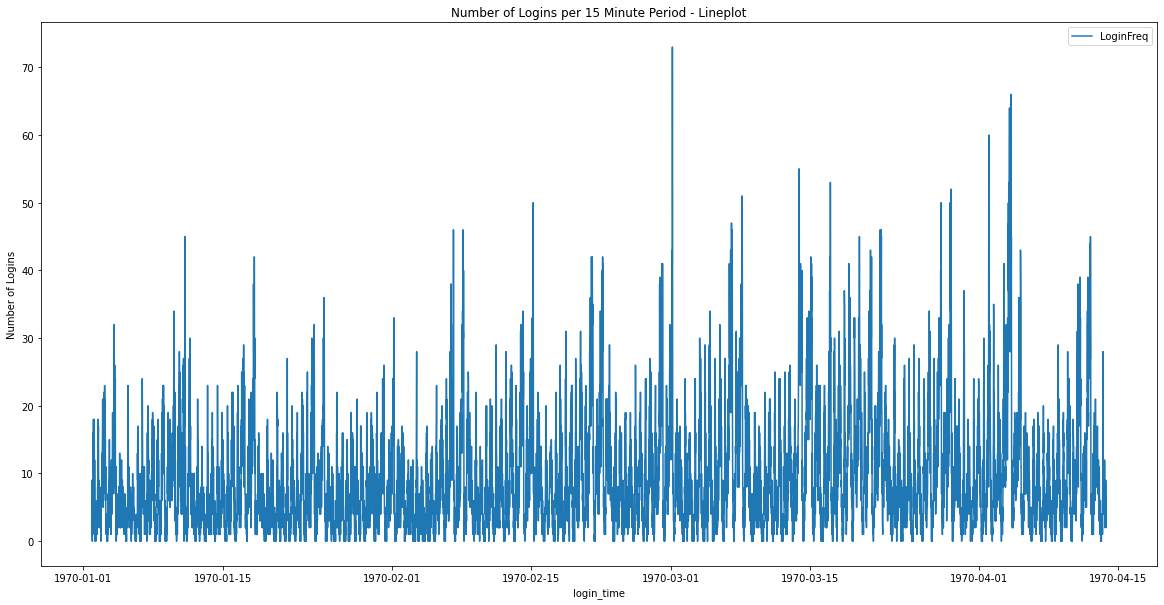

In [17]:
# Plot full data
_ = plt.figure(figsize=(20,10))
_ = sns.lineplot(data=logins)
_ = plt.title('Number of Logins per 15 Minute Period - Lineplot')
_ = plt.ylabel('Number of Logins')
plt.show()

Perform seasonal decomposition on weeklong periods

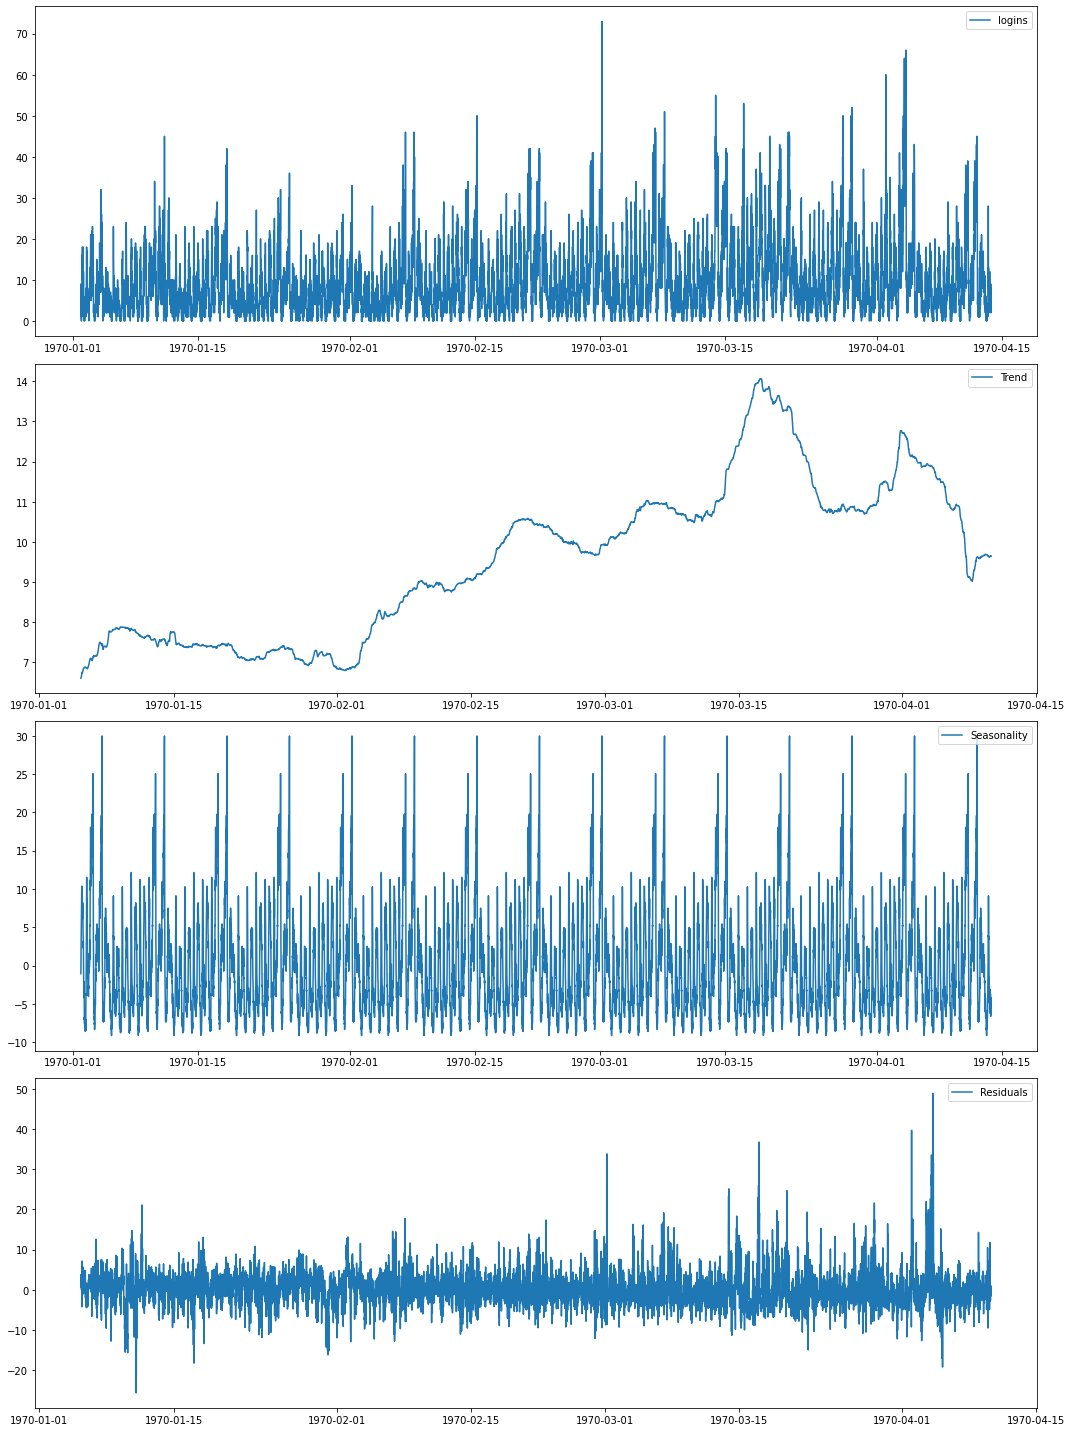

In [18]:
# Decompose time-series
decomposition = seasonal_decompose(logins['LoginFreq'], model='additive', period=(4*24*7))

# Extract parameters
trend = decomposition.trend
weekseasonality = decomposition.seasonal
res = decomposition.resid

# Plot the original data, the trend, the seasonality, and the residuals 
_ = plt.figure(figsize=(15,20))
_ = plt.subplot(411)
_ = plt.plot(logins['LoginFreq'], label = 'logins')
_ = plt.legend(loc = 'best')
_ = plt.subplot(412)
_ = plt.plot(trend, label = 'Trend')
_ = plt.legend(loc = 'best')
_ = plt.subplot(413)
_ = plt.plot(weekseasonality, label = 'Seasonality')
_ = plt.legend(loc = 'best')
_ = plt.subplot(414)
_ = plt.plot(res, label = 'Residuals')
_ = plt.legend(loc = 'best')
_ = plt.tight_layout()

- There is a clear seasonality for weeklong periods as well as a trend observed. Without data spanning over at least two years, it is impossible to tell if the apparent "trend" is meaningful or just representative of seasonality over the year.

Zoom in on seasonality over the week

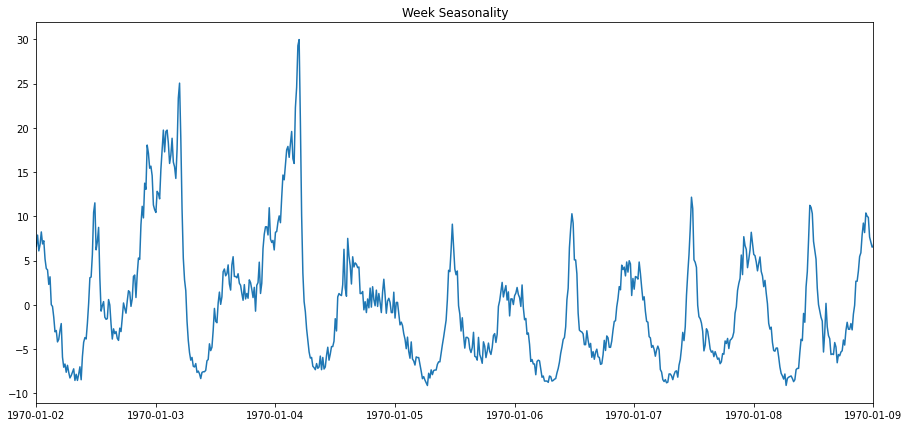

In [19]:
# Zoom in on weekly seasonality for time-series
_ = plt.figure(figsize=(15,7))
_ = plt.plot(weekseasonality)
_ = plt.title('Week Seasonality')
_ = plt.xlim('1970-01-02', '1970-01-09')
plt.show()

In [20]:
# Print weekdays that 1970-01-02 through 1970-01-04 occur on
print(logins.loc['1970-01-02':'1970-01-04'].weekday.unique())

['Friday' 'Saturday' 'Sunday']


- Friday and Saturday nights have large spikes. This represents the surge in people requesting ride-share services for weekend nightlife.

Decompose by daily periods and inspect the daily seasonality

In [23]:
# Decompose time-series
daydecomposition = seasonal_decompose(logins['LoginFreq'], model='additive', period=(4*24))

# Extract parameters
dayseasonality = daydecomposition.seasonal

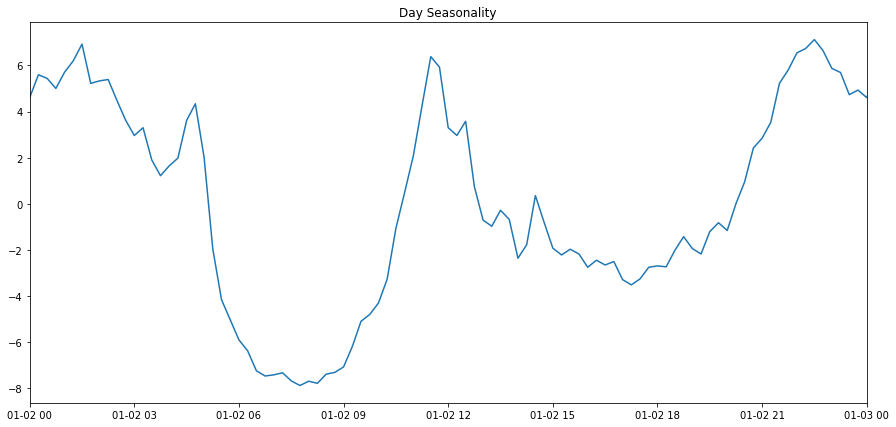

In [24]:
# Zoom in on day seasonality for time-series
_ = plt.figure(figsize=(15,7))
_ = plt.plot(dayseasonality)
_ = plt.title('Day Seasonality')
_ = plt.xlim('1970-01-02', '1970-01-03')
plt.show()

- There is a lull in requests between 5 and 9 am, with a spike between 9 and noon. There's a bit of a lull from noon to 6 pm, afterwhich there is a spike taking it through to midnight.

## Part 2 - Experiment and Metrics Design

###### Scenario:
- There is a two-way toll bridge between two nearby major cities resulting in drivers primarily working within one city at a time. It is in the best interest of the company to have the maximum number of drivers available for both cities at all times.

###### Proposed action:
- Reimburse all toll costs to drivers

###### Null Hypothesis:
- Reimbursing toll costs to drivers will not result in increased driver activity between cities

###### Key Success Metric:
 - Appropriate metric would reflect the ratio of rides given in city A vs city B, with a goal to minimize the difference between the two.
 - a = total rides given in city a in a day
 - b = total rides given in city b in a day
 - success metric = |(b - a) / (b + a)|
 
###### Experiment:
- A/B test on balanced sample of drivers. Total sample pool should have at least 100 drivers.
- Driver sample will reflect an equal number of drivers based in both cities. Day/Night and Weekday/Weekend drivers will be equaly represented in sampling as well. Selected drivers must drive at least 20 hours a week on average.
- Split driver sample in half. Offer one half reimbursed tolls and do nothing for other half.
- Log success metrics for each driver for one month.
- Calculate mean metric for reimbursed group.
- Determine estimate of normal distribution for non-reimbursed group.
- Perform p-test to determine if null hypothesis can be rejected. Use standard p-value of 0.05 as indicator of significance, unless there is rationale to do otherwise.

###### Interpretation:
- If the null hypopthesis is not rejected, it is possible that providing reimbursements to drivers is still not at ideal solution. 
- If that is the case, perhaps a deal can be made with the city wherein Ultimate is charged directly for driver tolls rather than the drivers being charged and subsequently reimbursed. Some drivers may not be financially willing to be charged directly for tolls even if they will be reimbursed by Ultimate. This could come in the form of Ultimate toll tags which can be billed directly by the city.
- It is also possible that the length of the experiment may not be long enough for drivers to adjust their driving patterns. Considerations should be made for extending the length of the experiment to 6 - 12 months in order to collect more meaningful data.